# Classical time-series Forecasting Models - Traffic & Electricity benchmarks

- **Master Thesis**: *'Time Series Forecasting using Transformers'*
- **Author**: Andrés Carrillo López
- **Thesis Tutor**: Pablo Martínez Olmos

**Goal of this notebook**: Once retrieved the Electricity and Traffic benchmark datasets in aggregated format, a series of classical forecasting models (such as *(S)ARIMA*, SES and *Holt-Winters ES*) will be tested on the available data and their performance will be evaluated, to serve as benchmark models for later comparison on deep learning and transformer models analyzed in this thesis.

## Setup

In [2]:
!pip install statsmodels --upgrade -q
!pip install pmdarima -q

In [1]:
# Dataframe, computational and visualization libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
# Setting plot styles
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

In [2]:
# Error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
import pmdarima as pm # has auto_arima function

from statsmodels.tsa.api import SimpleExpSmoothing # SES

from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holt-Winters Exp.Smoothing

https://towardsdatascience.com/lets-forecast-your-time-series-using-classical-approaches-f84eb982212c

https://www.statsmodels.org/stable/examples/index.html#time-series-analysis

In [ ]:
# Mounting Google drive on this notebook environment
from google.colab import drive
drive.mount('/content/drive')
%cd "drive/MyDrive/Máster Big Data (2020-2021)/TFM/Code Notebooks"

In [3]:
# Defining time indexes for hourly data.
last_week = -168 # last 168 hours (7 days) of training data. Plotted data starts here
next_day = 24
next_4_days = 24*4
next_week = 24*7

In [4]:
# Creating a custom function for forecast predictions
def plot_model_forecast(train_data, test_data, pred_data, forecast_t, dataset_str, forecast_method):
    """
    train_data: ndarray containing the data used for fitting the forecast model.
    test_data: ndarray containing the reserved test data.
    pred_data: ndarray containing the forecast for <forecast_t> hours.
    forecast_t: int with the number of hours of forecast.
    dataset_str: str with benchmark data case: "traffic" or "electr".
    forecast_method: str with model name (for labelling plot).
    """
    
    plt.plot(train_data[last_week:], label='Past data')
    plt.plot([None for i in train_data[last_week:]] + [x for x in test_data[:forecast_t]], label='True')
    plt.plot([None for i in train_data[last_week:]] + [x for x in pred_data[:forecast_t]], label='Forecast')
    
    t_case = "Electricity consumption" if dataset_str == "electr" else "Line (traffic) occupation rate"
    y_case = "Electricity consumption (KWh)" if dataset_str == "electr" else "Occupation rate"

    plt.title(f"{t_case} {str(forecast_t)} hr(s). forecast - {forecast_method} method.")
    plt.ylabel(y_case)
    plt.xlabel("Time (hours)")
    plt.legend()
    plt.show();

In [30]:
def plot_model_comparison(train_data, test_data, pred_data_list, forecast_t, dataset_str, forecast_methods_list):
    """
    Plots the train, test, and predicted forecasts for the considered models, for comparison.
    
    train_data: ndarray containing the data used for fitting the forecast model.
    test_data: ndarray containing the reserved test data.
    pred_data_list: [ndarray] containing the forecasts of the different models for <forecast_t> hours.
    forecast_t: int with the number of hours of forecast.
    dataset_str: str with benchmark data case: "traffic" or "electr".
    forecast_method_list: [str] with models names (for labelling plot).
    """
    
    plt.plot(train_data[last_week:], label='Past data')
    plt.plot([None for i in train_data[last_week:]] + [x for x in test_data[:forecast_t]], label='True')
    
    for model_i, pred_data in enumerate(pred_data_list):
        model_name = forecast_methods_list[model_i]
        plt.plot([None for i in train_data[last_week:]] + [x for x in pred_data[:forecast_t]], label=model_name)
    
    t_case = "Electricity consumption" if dataset_str == "electr" else "Line (traffic) occupation rate"
    y_case = "Electricity consumption (KWh)" if dataset_str == "electr" else "Occupation rate"
    plt.title(f"{t_case} {str(forecast_t)} hr(s). forecast - Methods comparison.")
    plt.ylabel(y_case), plt.xlabel("Time (hours)"), plt.legend()
    plt.show();

## Electricity Dataset

### Dataset Load and Preparation

We will first load the raw dataset and then add a 'date' column, as well as considering that each column is a different time series:

In [34]:
#electr_df = pd.read_csv("data/aggr_data/electricity.txt", header=None)
#electr_df['date'] = pd.date_range(start='1/1/2012', periods=electr_df.shape[0], freq="H")
# reorder columns
#cols = electr_df.columns.tolist() 
#cols = cols[-1:] + cols[:-1]
#electr_df = electr_df[cols]
#electr_df.to_csv("data/aggr_data/electr_proc_data.csv") #to later use with library
# showing sample
electr_df = pd.read_csv("data/aggr_data/electr_proc_data.csv", index_col=0)
electr_df

,date,0,1,2,3,4,5,6,7,8,...,311,312,313,314,315,316,317,318,319,320
0,2012-01-01 00:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,2012-01-01 01:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,2012-01-01 02:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,2012-01-01 03:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,2012-01-01 04:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2014-12-31 19:00:00,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,...,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0,2773.0
26300,2014-12-31 20:00:00,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,...,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0,2755.0
26301,2014-12-31 21:00:00,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,...,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0,2650.0
26302,2014-12-31 22:00:00,10.0,92.0,8.0,646.0,349.0,1261.0,48.0,1009.0,288.0,...,833.0,1227.0,141900.0,6546.0,5502.0,259.0,33.0,2623.0,783.0,2719.0


Now, for performance evaluation, we will split our series in a train set consisting of the first 70% hours, and the test set using the following 30%.

In [35]:
data = electr_df["320"].values # We will pick this particular series for the experiment

train_size = int(len(data) * 0.7) # 70% of the data (past)
train, test = data[0:train_size], data[train_size:len(data)]

true_1day = test[:24]
true_4day = test[:24*4]
true_1week = test[:168] # (next week , i.e. first 168 hours from train data last point)

print('Number of observations: %d (hours)' % (len(data)))
print('Num. of Training Observations: %d (hours)' % (len(train)))
print('Num. of Test Observations: %d (hours)' % (len(test)))

Number of observations: 26304 (hours)
Num. of Training Observations: 18412 (hours)
Num. of Test Observations: 7892 (hours)


### (Seasonal) ARIMA

https://robjhyndman.com/hyndsight/seasonal-periods/

In [ ]:
#Note: our hourly data has the 'multiple-seasonality' problem that ARIMA/SARIMA models cannot deal with

In [ ]:
model = pm.auto_arima(train[:-365*24], m=24, trace=True,random_state=42) #hourly freq.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=30.90 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=126883.869, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=125086.200, Time=11.75 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=125750.863, Time=10.73 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=126881.870, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=126826.876, Time=0.25 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=124446.252, Time=42.62 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=107.61 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=24.72 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=124559.564, Time=39.57 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=124418.655, Time=59.47 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=125076.714, Time=15.74 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=138.04 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=28.94 sec
 ARIMA(3,1,0)

In [32]:
# Save model to disk:
#joblib.dump(model, "trained_models/arima_model_electr.pkl", compress=3)

# Load model from disk after fitting
arima_model = joblib.load("trained_models/arima_model_electr.pkl")

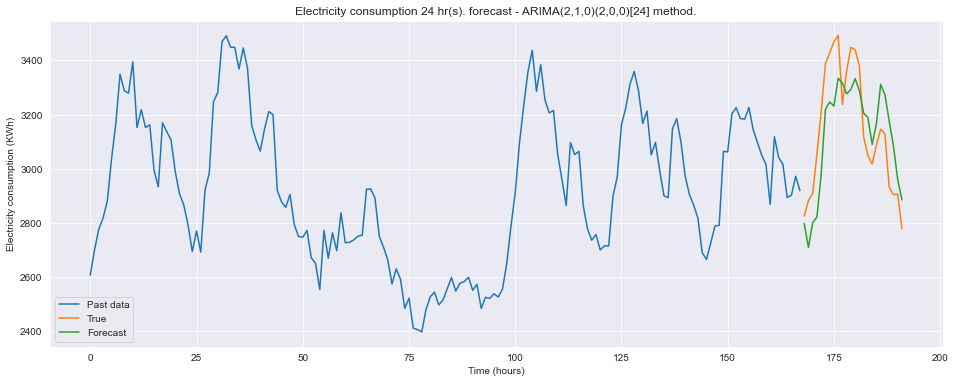

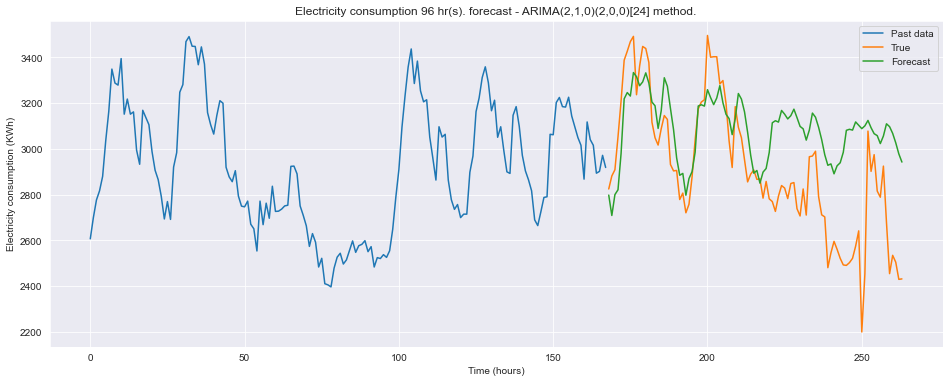

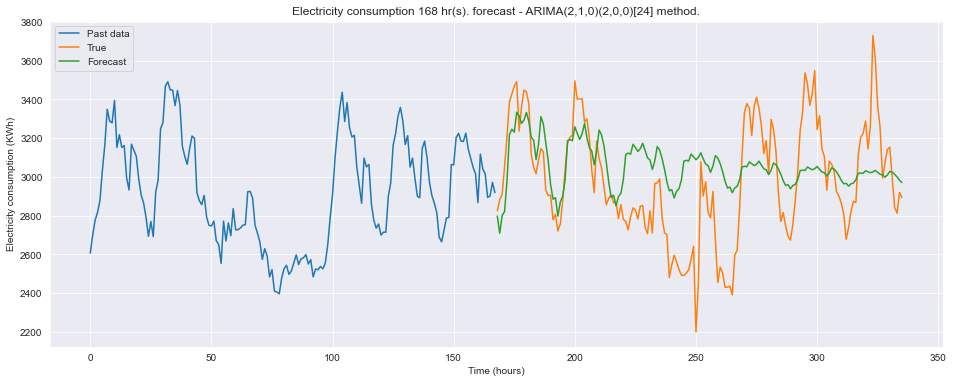

In [36]:
forecast_1day_ARIMA = arima_model.predict(next_day)
plot_model_forecast(train, test, forecast_1day_ARIMA, next_day, "electr","ARIMA(2,1,0)(2,0,0)[24]")

forecast_4day_ARIMA = arima_model.predict(next_4_days) 
plot_model_forecast(train, test, forecast_4day_ARIMA, next_4_days, "electr","ARIMA(2,1,0)(2,0,0)[24]")

forecast_1week_ARIMA = arima_model.predict(next_week) 
plot_model_forecast(train, test, forecast_1week_ARIMA, next_week, "electr","ARIMA(2,1,0)(2,0,0)[24]")

In [37]:
rmse_1day = np.sqrt(mean_squared_error(true_1day, forecast_1day_ARIMA) )
mae_1day = mean_absolute_error(true_1day, forecast_1day_ARIMA)

rmse_4day = np.sqrt(mean_squared_error(true_4day, forecast_4day_ARIMA) )
mae_4day = mean_absolute_error(true_4day, forecast_4day_ARIMA)

rmse_1week = np.sqrt(mean_squared_error(true_1week, forecast_1week_ARIMA) )
mae_1week = mean_absolute_error(true_1week, forecast_1week_ARIMA)

print("[ARIMA] 1 day forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse_1day, mae_1day))
print("[ARIMA] 4 day forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse_4day, mae_4day))
print("[ARIMA] 1 week forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse_1week, mae_1week))

[ARIMA] 1 day forecast - RMSE: 150.27. MAE: 137.72.
[ARIMA] 4 day forecast - RMSE: 294.52. MAE: 233.85.
[ARIMA] 1 week forecast - RMSE: 278.20. MAE: 223.40.


### Simple Exponential Smoothing (SES)

In [38]:
simple_ES = SimpleExpSmoothing(train, initialization_method="estimated").fit()

/Users/andrescarrillo/opt/anaconda3/envs/eB2-Data/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
# TODO: Show model parameters

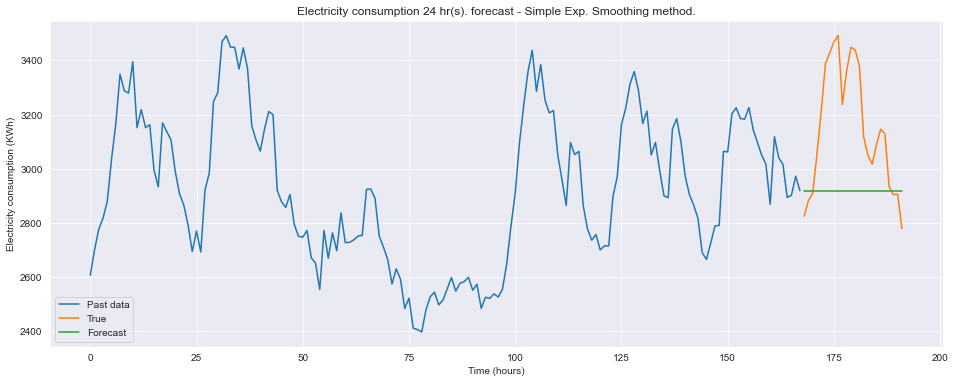

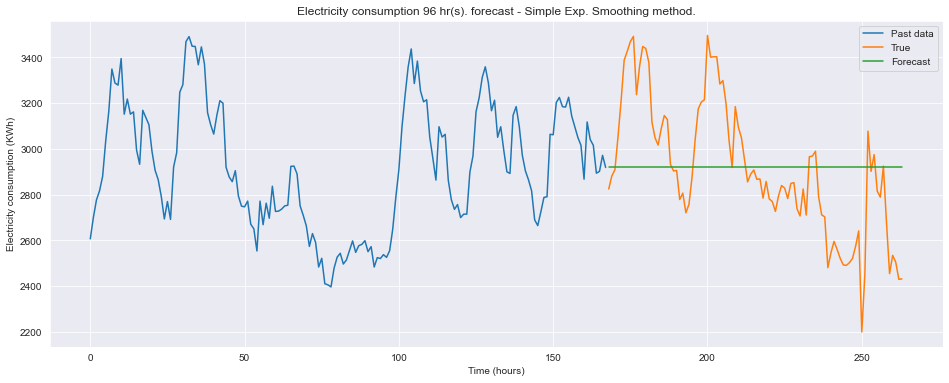

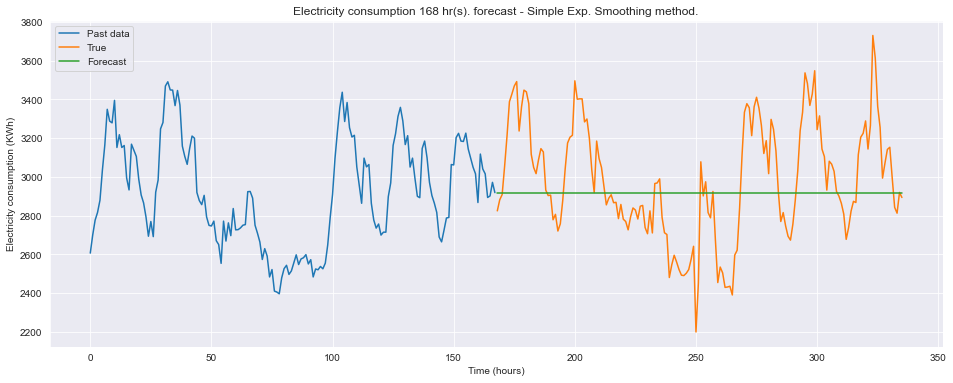

In [39]:
# Generating a 1-day forecast
forecast_1day_SES = simple_ES.forecast(next_day)
plot_model_forecast(train, test, forecast_1day_SES, next_day, "electr", "Simple Exp. Smoothing")
# Generating a 4-day forecast
forecast_4day_SES = simple_ES.forecast(next_4_days)
plot_model_forecast(train, test, forecast_4day_SES, next_4_days, "electr", "Simple Exp. Smoothing")
# Generating a 1-week forecast
forecast_1week_SES = simple_ES.forecast(next_week)
plot_model_forecast(train, test, forecast_1week_SES, next_week, "electr", "Simple Exp. Smoothing")

In [40]:
rmse_1day = np.sqrt(mean_squared_error(true_1day, forecast_1day_SES) )
mae_1day = mean_absolute_error(true_1day, forecast_1day_SES)

rmse_4day = np.sqrt(mean_squared_error(true_4day, forecast_4day_SES) )
mae_4day = mean_absolute_error(true_4day, forecast_4day_SES)

rmse_1week = np.sqrt(mean_squared_error(true_1week, forecast_1week_SES) )
mae_1week = mean_absolute_error(true_1week, forecast_1week_SES)

print("[SES] 1 day forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse_1day, mae_1day))
print("[SES] 4 day forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse_4day, mae_4day))
print("[SES] 1 week forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse_1week, mae_1week))

[SES] 1 day forecast - RMSE: 321.92. MAE: 256.04.
[SES] 4 day forecast - RMSE: 292.69. MAE: 235.02.
[SES] 1 week forecast - RMSE: 303.68. MAE: 246.01.


### Holt-Winters (Seasonal) Exponential Smoothing

In [41]:
# Lets estimate the best model for our training data:
holtwinter_ES = ExponentialSmoothing(train, trend='add',seasonal="add", 
                            seasonal_periods=24, #24 as for hourly data
                            damped_trend=True, use_boxcox=False,
                            initialization_method='heuristic').fit()

/Users/andrescarrillo/opt/anaconda3/envs/eB2-Data/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
# TODO: Show model parameters

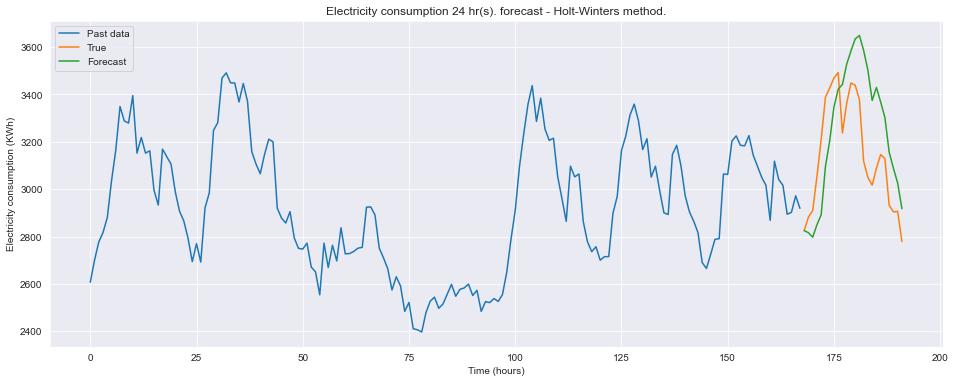

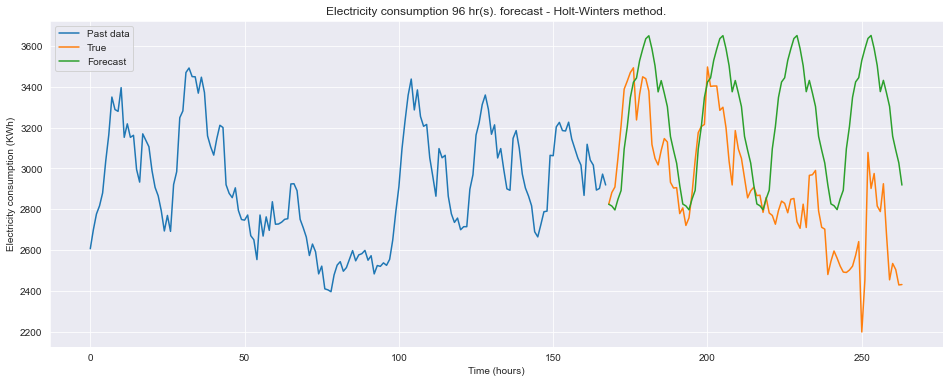

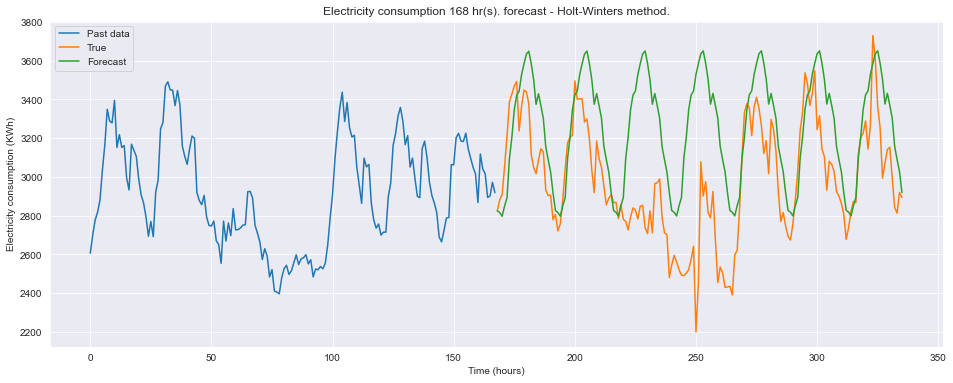

In [42]:
# Generating a 1-day forecast
forecast_1day_HWES = holtwinter_ES.forecast(next_day)
plot_model_forecast(train, test, forecast_1day_HWES, next_day, "electr", "Holt-Winters")
# Generating a 4-day forecast
forecast_4day_HWES = holtwinter_ES.forecast(next_4_days)
plot_model_forecast(train, test, forecast_4day_HWES, next_4_days, "electr", "Holt-Winters")
# Generating a 1-week forecast
forecast_1week_HWES = holtwinter_ES.forecast(next_week)
plot_model_forecast(train, test, forecast_1week_HWES, next_week, "electr", "Holt-Winters")

In [43]:
rmse_1day = np.sqrt(mean_squared_error(true_1day, forecast_1day_HWES) )
mae_1day = mean_absolute_error(true_1day, forecast_1day_HWES)

rmse_4day = np.sqrt(mean_squared_error(true_4day, forecast_4day_HWES) )
mae_4day = mean_absolute_error(true_4day, forecast_4day_HWES)

rmse_1week = np.sqrt(mean_squared_error(true_1week, forecast_1week_HWES) )
mae_1week = mean_absolute_error(true_1week, forecast_1week_HWES)

print("[Holt-Winters] 1 day forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse_1day, mae_1day))
print("[Holt-Winters] 4 day forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse_4day, mae_4day))
print("[Holt-Winters] 1 week forecast - RMSE: {:.2f}. MAE: {:.2f}.".format(rmse_1week, mae_1week))

[Holt-Winters] 1 day forecast - RMSE: 239.70. MAE: 210.86.
[Holt-Winters] 4 day forecast - RMSE: 461.99. MAE: 369.56.
[Holt-Winters] 1 week forecast - RMSE: 382.77. MAE: 297.00.


### Comparison of forecasting methods for Electr. Dataset

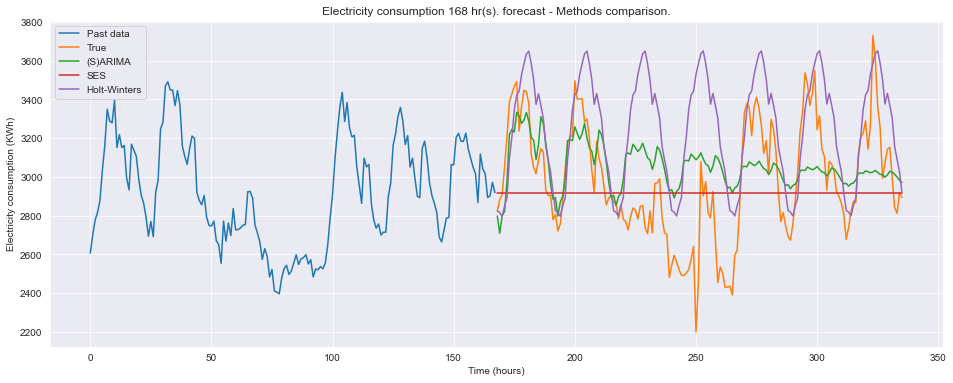

In [44]:
pred_data_list = [forecast_1week_ARIMA, forecast_1week_SES, forecast_1week_HWES]
forecast_methods_list = ["(S)ARIMA", "SES", "Holt-Winters"]
dataset_str = "electr"
forecast_t = next_week

plot_model_comparison(train, test, pred_data_list, forecast_t, dataset_str, forecast_methods_list)

## Traffic Dataset

### Dataset Load and Preparation

In [5]:
traffic_df = pd.read_csv("data/aggr_data/traffic.txt", header=None)
traffic_df['date'] = pd.date_range(start='1/1/2008', periods=traffic_df.shape[0], freq="H")
# reorder columns
cols = traffic_df.columns.tolist() 
cols = cols[-1:] + cols[:-1]
traffic_df = traffic_df[cols]
traffic_df.to_csv("data/aggr_data/traffic_proc_data.csv") #to later use with library
# showing sample
traffic_df = pd.read_csv("data/aggr_data/traffic_proc_data.csv", index_col=0)
traffic_df

,date,0,1,2,3,4,5,6,7,8,...,852,853,854,855,856,857,858,859,860,861
0,2008-01-01 00:00:00,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,2008-01-01 01:00:00,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,2008-01-01 02:00:00,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,2008-01-01 03:00:00,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,2008-01-01 04:00:00,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2009-12-31 19:00:00,0.0342,0.0332,0.1378,0.0559,0.0165,0.0386,0.0457,0.0687,0.0716,...,0.0139,0.0179,0.0278,0.0280,0.0227,0.0375,0.0142,0.0201,0.0341,0.0429
17540,2009-12-31 20:00:00,0.0285,0.0253,0.0542,0.0485,0.0131,0.0331,0.0372,0.0569,0.0669,...,0.0116,0.0155,0.0201,0.0267,0.0207,0.0320,0.0122,0.0163,0.0306,0.0363
17541,2009-12-31 21:00:00,0.0276,0.0257,0.0551,0.0474,0.0121,0.0326,0.0381,0.0566,0.0675,...,0.0109,0.0142,0.0208,0.0252,0.0189,0.0287,0.0123,0.0152,0.0292,0.0325
17542,2009-12-31 22:00:00,0.0232,0.0229,0.0496,0.0435,0.0119,0.0297,0.0361,0.0517,0.0598,...,0.0092,0.0124,0.0219,0.0215,0.0169,0.0258,0.0096,0.0130,0.0252,0.0279


In [48]:
data = traffic_df["0"].values # We will pick this particular series for the experiment

train_size = int(len(data) * 0.7) # 70% of the data (past)
train, test = data[0:train_size], data[train_size:len(data)]

true_1day = test[:24]
true_4day = test[:24*4]
true_1week = test[:168]

print('Number of observations: %d (hours)' % (len(data)))
print('Num. of Training Observations: %d (hours)' % (len(train)))
print('Num. of Test Observations: %d (hours)' % (len(test)))

Number of observations: 17544 (hours)
Num. of Training Observations: 12280 (hours)
Num. of Test Observations: 5264 (hours)


### (Seasonal) ARIMA

In [8]:
model = pm.auto_arima(train[:-365*24], m=24, trace=True,random_state=42) #hourly freq.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=-13911.779, Time=22.33 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-9985.051, Time=0.26 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-13805.181, Time=7.26 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-13061.217, Time=5.90 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-8284.538, Time=0.13 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=-13381.021, Time=21.59 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=-13904.600, Time=18.80 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=-13964.442, Time=63.97 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=-13945.693, Time=65.03 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=inf, Time=94.62 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=-14003.280, Time=82.08 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=-13974.816, Time=74.18 sec
 ARIMA(1,0,2)(1,0,2)[24] intercept   : AIC=-14030.563, Time=70.15 sec
 ARIMA(1,0,2)(0,0,2)[24] intercept   : AIC=-13976.544, Time=

In [46]:
# Save model to disk:
#joblib.dump(model, "trained_models/arima_model_traffic.pkl", compress=3)

# Load model from disk after fitting
arima_model = joblib.load("trained_models/arima_model_traffic.pkl")

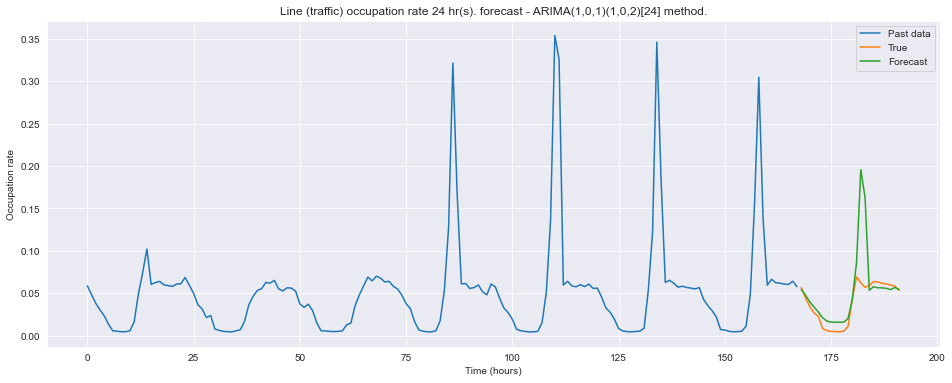

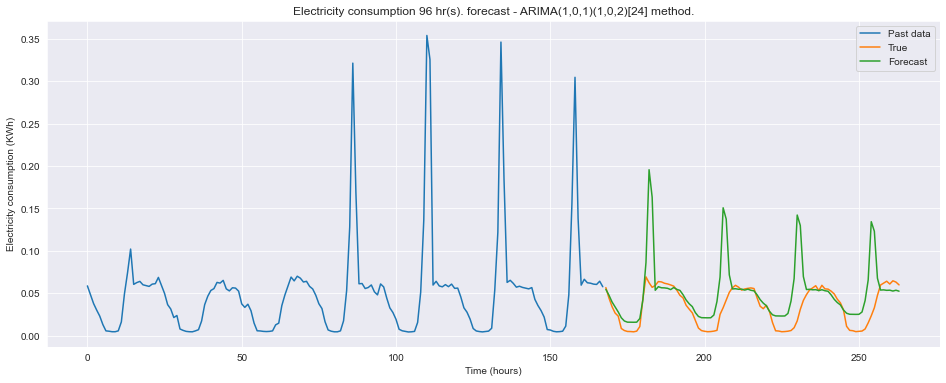

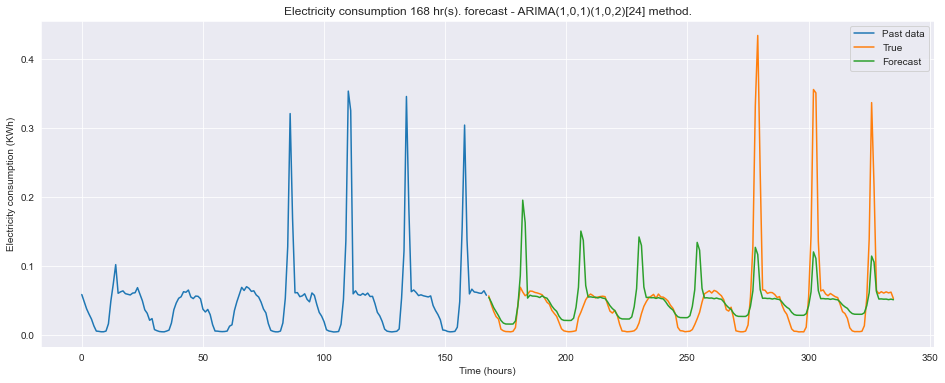

In [49]:
forecast_1day_ARIMA = arima_model.predict(next_day)
plot_model_forecast(train, test, forecast_1day_ARIMA, next_day, "traffic","ARIMA(1,0,1)(1,0,2)[24]")

forecast_4day_ARIMA = arima_model.predict(next_4_days) 
plot_model_forecast(train, test, forecast_4day_ARIMA, next_4_days, "electr","ARIMA(1,0,1)(1,0,2)[24]")

forecast_1week_ARIMA = arima_model.predict(next_week) 
plot_model_forecast(train, test, forecast_1week_ARIMA, next_week, "electr","ARIMA(1,0,1)(1,0,2)[24]")

In [50]:
rmse_1day = np.sqrt(mean_squared_error(true_1day, forecast_1day_ARIMA) )
mae_1day = mean_absolute_error(true_1day, forecast_1day_ARIMA)

rmse_4day = np.sqrt(mean_squared_error(true_4day, forecast_4day_ARIMA) )
mae_4day = mean_absolute_error(true_4day, forecast_4day_ARIMA)

rmse_1week = np.sqrt(mean_squared_error(true_1week, forecast_1week_ARIMA) )
mae_1week = mean_absolute_error(true_1week, forecast_1week_ARIMA)

print("[ARIMA] 1 day forecast - RMSE: {:.4f}. MAE: {:.4f}.".format(rmse_1day, mae_1day))
print("[ARIMA] 4 day forecast - RMSE: {:.4f}. MAE: {:.4f}.".format(rmse_4day, mae_4day))
print("[ARIMA] 1 week forecast - RMSE: {:.4f}. MAE: {:.4f}.".format(rmse_1week, mae_1week))

[ARIMA] 1 day forecast - RMSE: 0.0356. MAE: 0.0165.
[ARIMA] 4 day forecast - RMSE: 0.0352. MAE: 0.0192.
[ARIMA] 1 week forecast - RMSE: 0.0547. MAE: 0.0264.


### Simple Exponential Smoothing (SES)

In [ ]:
simple_ES = SimpleExpSmoothing(train, initialization_method="estimated").fit()

In [ ]:
# TODO: Show model parameters

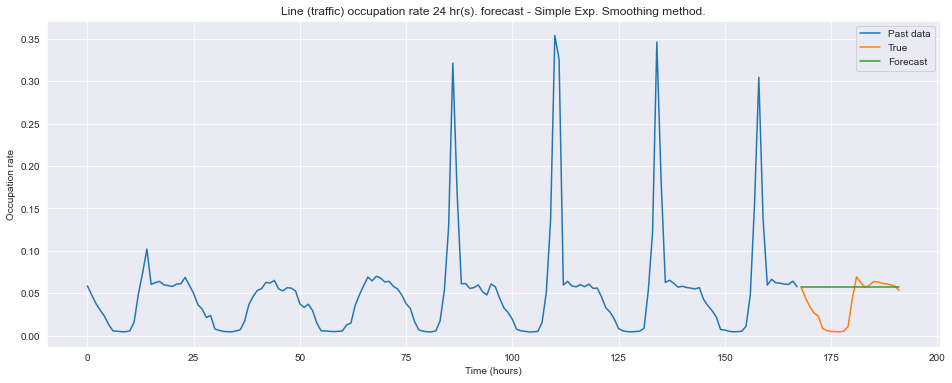

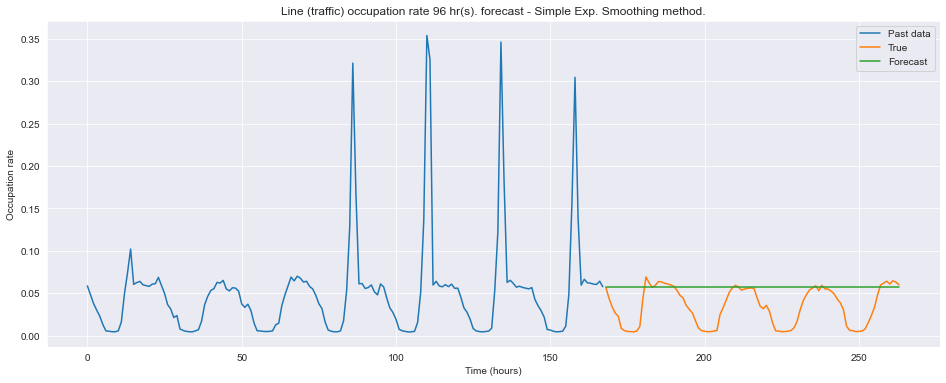

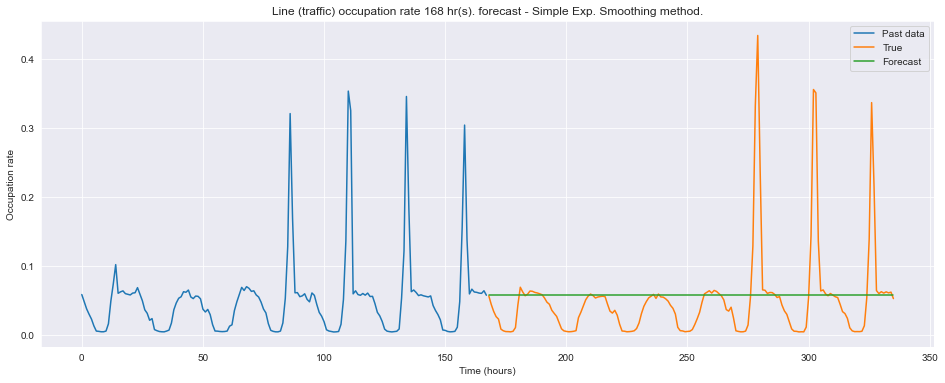

In [51]:
# Generating a 1-day forecast
forecast_1day_SES = simple_ES.forecast(next_day)
plot_model_forecast(train, test, forecast_1day_SES, next_day, "traffic", "Simple Exp. Smoothing")
# Generating a 4-day forecast
forecast_4day_SES = simple_ES.forecast(next_4_days)
plot_model_forecast(train, test, forecast_4day_SES, next_4_days, "traffic", "Simple Exp. Smoothing")
# Generating a 1-week forecast
forecast_1week_SES = simple_ES.forecast(next_week)
plot_model_forecast(train, test, forecast_1week_SES, next_week, "traffic", "Simple Exp. Smoothing")

In [52]:
rmse_1day = np.sqrt(mean_squared_error(true_1day, forecast_1day_SES) )
mae_1day = mean_absolute_error(true_1day, forecast_1day_SES)

rmse_4day = np.sqrt(mean_squared_error(true_4day, forecast_4day_SES) )
mae_4day = mean_absolute_error(true_4day, forecast_4day_SES)

rmse_1week = np.sqrt(mean_squared_error(true_1week, forecast_1week_SES) )
mae_1week = mean_absolute_error(true_1week, forecast_1week_SES)

print("[SES] 1 day forecast - RMSE: {:.4f}. MAE: {:.4f}.".format(rmse_1day, mae_1day))
print("[SES] 4 day forecast - RMSE: {:.4f}. MAE: {:.4f}.".format(rmse_4day, mae_4day))
print("[SES] 1 week forecast - RMSE: {:.4f}. MAE: {:.4f}.".format(rmse_1week, mae_1week))

[SES] 1 day forecast - RMSE: 0.0301. MAE: 0.0217.
[SES] 4 day forecast - RMSE: 0.0316. MAE: 0.0242.
[SES] 1 week forecast - RMSE: 0.0650. MAE: 0.0353.


### Holt-Winters (Seasonal) Exponential Smoothing

In [53]:
# Lets estimate the best model for our training data:
holtwinter_ES = ExponentialSmoothing(train, trend='add',seasonal="add", 
                            seasonal_periods=24, #24 as for hourly data
                            damped_trend=True, use_boxcox=False,
                            initialization_method='heuristic').fit()

In [ ]:
# TODO: Show model parameters

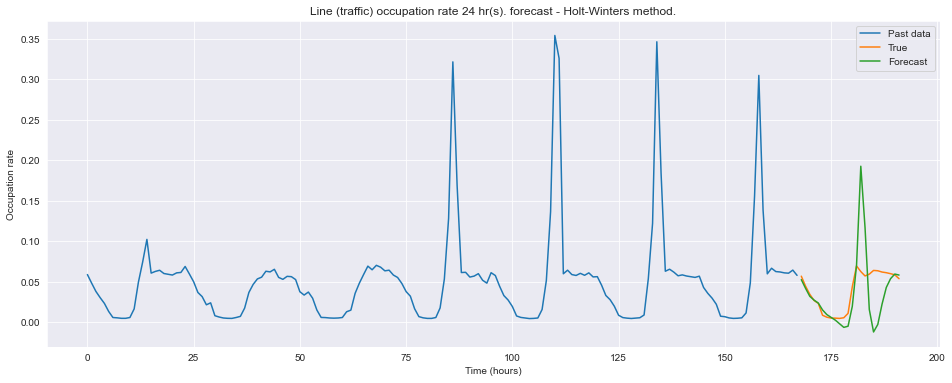

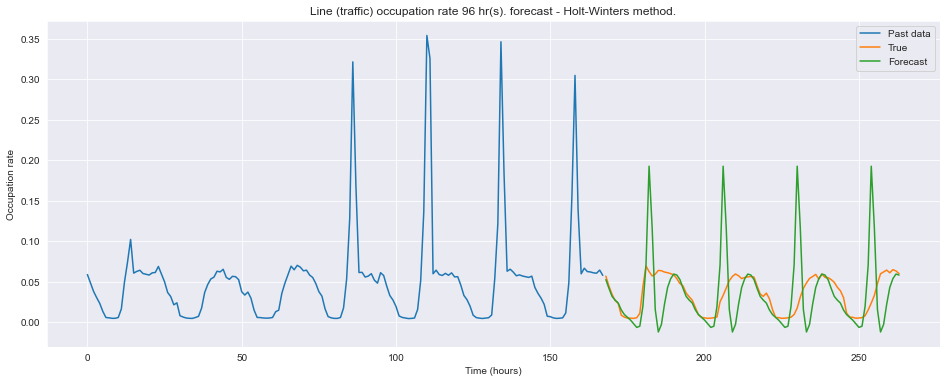

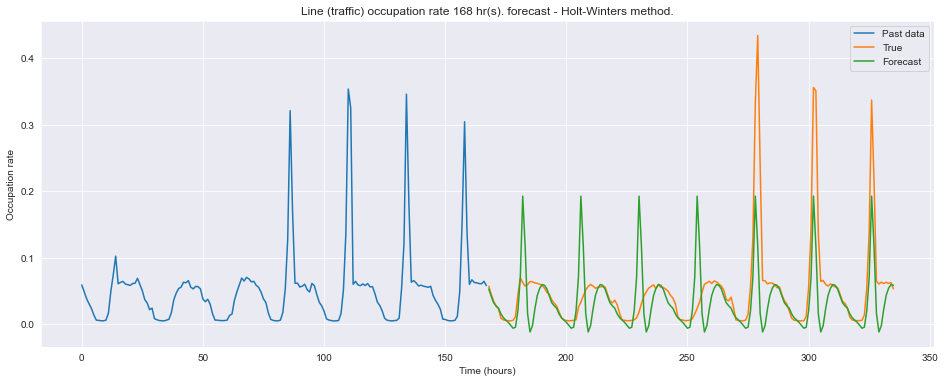

In [54]:
# Generating a 1-day forecast
forecast_1day_HWES = holtwinter_ES.forecast(next_day)
plot_model_forecast(train, test, forecast_1day_HWES, next_day, "traffic", "Holt-Winters")
# Generating a 4-day forecast
forecast_4day_HWES = holtwinter_ES.forecast(next_4_days)
plot_model_forecast(train, test, forecast_4day_HWES, next_4_days, "traffic", "Holt-Winters")
# Generating a 1-week forecast
forecast_1week_HWES = holtwinter_ES.forecast(next_week)
plot_model_forecast(train, test, forecast_1week_HWES, next_week, "traffic", "Holt-Winters")

In [55]:
rmse_1day = np.sqrt(mean_squared_error(true_1day, forecast_1day_HWES) )
mae_1day = mean_absolute_error(true_1day, forecast_1day_HWES)

rmse_4day = np.sqrt(mean_squared_error(true_4day, forecast_4day_HWES) )
mae_4day = mean_absolute_error(true_4day, forecast_4day_HWES)

rmse_1week = np.sqrt(mean_squared_error(true_1week, forecast_1week_HWES) )
mae_1week = mean_absolute_error(true_1week, forecast_1week_HWES)

print("[Holt-Winters] 1 day forecast - RMSE: {:.4f}. MAE: {:.4f}.".format(rmse_1day, mae_1day))
print("[Holt-Winters] 4 day forecast - RMSE: {:.4f}. MAE: {:.4f}.".format(rmse_4day, mae_4day))
print("[Holt-Winters] 1 week forecast - RMSE: {:.4f}. MAE: {:.4f}.".format(rmse_1week, mae_1week))

[Holt-Winters] 1 day forecast - RMSE: 0.0385. MAE: 0.0220.
[Holt-Winters] 4 day forecast - RMSE: 0.0439. MAE: 0.0248.
[Holt-Winters] 1 week forecast - RMSE: 0.0567. MAE: 0.0299.


### Comparison of forecasting methods for Traffic Dataset

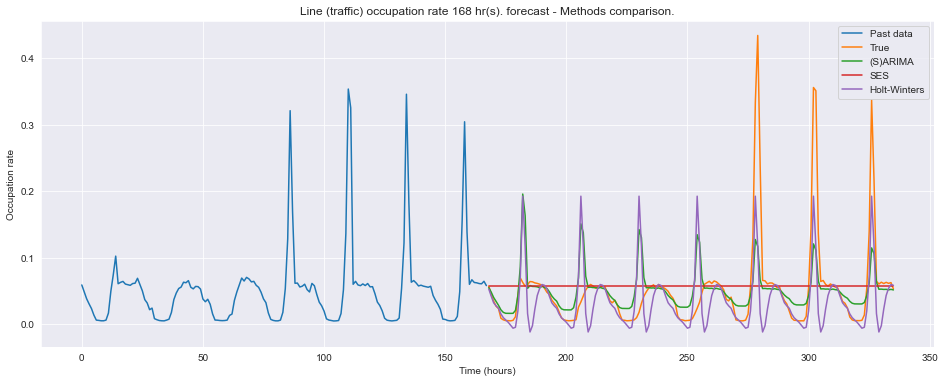

In [56]:
pred_data_list = [forecast_1week_ARIMA, forecast_1week_SES, forecast_1week_HWES]
forecast_methods_list = ["(S)ARIMA", "SES", "Holt-Winters"]
dataset_str = "traffic"
forecast_t = next_week

plot_model_comparison(train, test, pred_data_list, forecast_t, dataset_str, forecast_methods_list)